# Q-learningの考え方を迷路問題を用いて確認する

In [1]:
import numpy as np
from collections import defaultdict

try:
    from google.colab import files
    print('Google Colab. 上での実行です')
    print('「ファイルを選択」から、notebook/commonフォルダの中身を全て選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir common
    !mv *.py ./common
except:
    print('ローカル環境での実行です')


from common.agent import CommonAgent
from common.show_value import show_q_value
from common.meiro import Environment

Google Colab. 上での実行です
「ファイルを選択」から、notebook/commonフォルダの中身を全て選択し、アップロードしてください


Saving agent.py to agent.py
Saving meiro.py to meiro.py
Saving planner.py to planner.py
Saving show_value.py to show_value.py


In [2]:
class QLearningAgent(CommonAgent):
    """
    Q学習法のエージェントクラス
    """
    
    def __init__(self, epsilon=0.1):
        """
        epsilon : float, 探索する確率
        """
        # CommonAgentクラスの__init__メソッドを実行する
        super().__init__(epsilon)
    
    def policy(self, s, actions):
        """
        方策関数(epsilon-greedy法)
        """
        if np.random.random() < self.epsilon:
            """
            探索
            """
            return np.random.choice(actions)
        else:
            """
            利用
            """
            if s in self.Q and sum(self.Q[s]) != 0:
                # 行動価値Qが最大になる行動aのインデックスを返す
                return np.argmax(self.Q[s])
            else:
                """
                例外処理
                """
                return np.random.choice(actions)

    def learn(self, env, episode_num=1000, gamma=0.9, report_interval=50, alpha=0.01):
        """
        学習を実行するメソッド
        episode_num : エピソード数
        gamma : 割引率
        report_interval : 結果を表示させる間隔
        alpha : 学習率
        """
        
        # 初期化
        self.init_log()
        actions = env.actions # 行動の種類
        num_actions = len(actions)
        self.Q = defaultdict(lambda: [0] * num_actions) # 行動価値
        
        # エピソードのループ
        for e in range(episode_num):
            
            # 初期化
            s = env.reset()
            done = False
            
            # 1エピソードを実行
            while not done:
                
                # 現在の方策に基づいて、行動をとる
                a = self.policy(s, actions)
                next_state, reward, done = env.step(a)
                
                # TD誤差を求める
                gain = reward + gamma * max(self.Q[next_state]) # 行動価値が最大になる行動が最善であると考える
                estimated = self.Q[s][a]
                td = (gain - estimated) 
                
                # 行動価値Qを更新する
                self.Q[s][a] += alpha *td 
                
                # 状態を更新する
                s = next_state

            # 最後の報酬を記録しておく
            self.log(reward)

            # 報酬を表示する
            if e != 0 and e % report_interval == 0:
                self.show_rewards_log(episode=e)

## 実行

In [3]:
# 迷路の条件を設定する
grid = np.array([[0,0,0,0],[0,-1,0,-1],[0,0,0,-1],[-1,0,0,1]])

# 環境をつくる
env = Environment(grid, move_prob=0.95, agent_init_state=(0,0))

# エージェントをつくる
agent = QLearningAgent(epsilon=0.1)

# 学習の実行
agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.1)


At Episode 50 average reward is 0.12 (+/-0.993).
At Episode 100 average reward is 0.72 (+/-0.694).
At Episode 150 average reward is 0.72 (+/-0.694).
At Episode 200 average reward is 0.64 (+/-0.768).
At Episode 250 average reward is 0.76 (+/-0.65).
At Episode 300 average reward is 0.48 (+/-0.877).
At Episode 350 average reward is 0.76 (+/-0.65).
At Episode 400 average reward is 0.64 (+/-0.768).
At Episode 450 average reward is 0.72 (+/-0.694).


## 結果の可視化

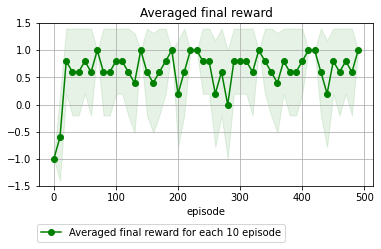

In [4]:
# agent.rewards_logに保存している各エピソードの最終報酬額を可視化する
# 全エピソードを表示させると傾向を捉えにくくなるため、10エピソード毎に平均をとっている
# 学習が進むと、エージェントはゴールできるようになってくるため、値は1(ゴール時の報酬)に近づく
agent.show_rewards_log(interval=10)

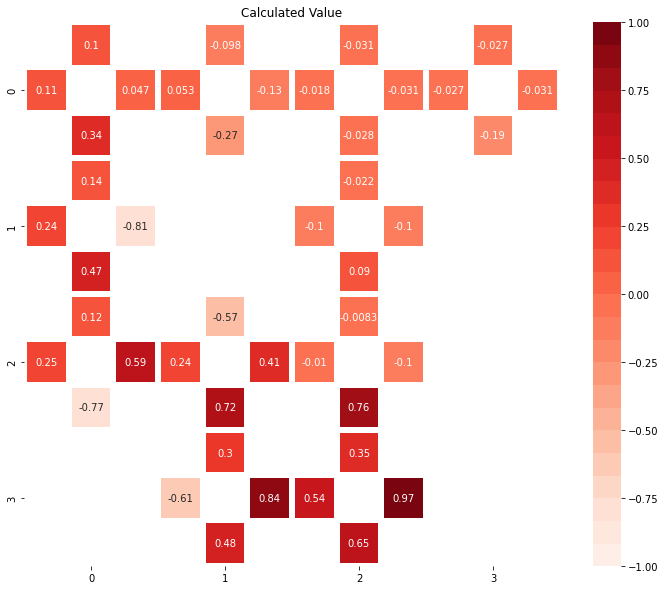

In [5]:
# 学習によって求めた行動価値Qを可視化する
# 行動価値は、通常セル毎に4つの値(UP,DOWN,LEFT,RIGTH)を持っている
# 以下のグラフでは、通常セルを中心に、上下左右の4つのセルに値を配置した
show_q_value(agent.Q, row=grid.shape[0], col=grid.shape[1])    

* SARSAにくらべ、全体的にQ値が大きくなっている。これは、行動価値が最大になる行動をとるように行動価値が更新されるため、穴に落ちるという行動がほとんど選択されないためである

### [演習]
* grid条件、エージェントの初期位置、epsilon、alphaなどを変更して、学習の進み具合を確認しましょう